imports

In [1]:
import matplotlib.pyplot as plt
import torch
import sys
import os
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange
import numpy as np

import warnings
warnings.filterwarnings("ignore")
sys.path.insert(1, '../train')
sys.path.insert(1, '../misc')

import config_plots, TrialStatistics
import CNN, dataLoader
from configParser import ConfigParser, getModelName, getDatasetName
config_plots.global_settings()

parameters

In [2]:
experimentName = "dummy_experiment"
experimentsPath="/raid/elhamod/Fish/official_experiments/" # Where experiment results will be produced
dataPath="/raid/elhamod/Fish" # Where data is

generate_confusion_matrix = False

cuda=1

Cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 1


Setup

In [4]:
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

experimentPathAndName = os.path.join(experimentsPath, experimentName)

# instantiate trial stat object
results_dir = os.path.join(experimentPathAndName, "results")
ts = TrialStatistics.TrialStatistics(results_dir)
ts_coarse = TrialStatistics.TrialStatistics(results_dir, "coarse")

datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

paramsIterator = config_parser.getExperiments()  
number_of_experiments = sum(1 for e in paramsIterator)  

Show and save trial statistics

In [5]:

with tqdm(total=number_of_experiments, desc="experiment") as bar:
    for experiment_params in config_parser.getExperiments():
        print(experiment_params)

        # For analyzing experiments, we don't care about augmentation
        datasetManager.updateParams(config_parser.fixPaths(experiment_params))
        train_loader, validation_loader, test_loader = datasetManager.getLoaders()
        fineList = train_loader.dataset.csv_processor.getFineList()
        coarseList = train_loader.dataset.csv_processor.getCoarseList()
        architecture = {
            "fine": len(fineList),
            "coarse" : len(coarseList)
        }


        
        # Loop through n trials
        for i in trange(experiment_params["numOfTrials"], desc="trial"):
            modelName = getModelName(experiment_params, i)
            trialName = os.path.join(experimentPathAndName, modelName)
            
            # Train/Load model
            print(CNN.getModelFile(trialName))
            model = CNN.create_model(architecture, experiment_params, device=cuda)
            if os.path.exists(CNN.getModelFile(trialName)):
                df, epochs, time_elapsed = CNN.loadModel(model, trialName, device=cuda)
                
                # Update trial outcomes for statistics
                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, device=cuda)
                loss = CNN.getCrossEntropy(predlist, lbllist)
                avg_prob = CNN.getAvgProbCorrectGuess(predlist, lbllist)
                topk = CNN.top_k_acc(predlist, lbllist, topk=(3,5))
                
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                labels =list(map(lambda x: x[1] + " - " + str(x[0]), enumerate(fineList))) 
                ts.addTrialPredictions(experiment_params,i, predlist, lbllist, labels)
                micro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, 'coarse', device=cuda)
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                labels =list(map(lambda x: x[1] + " - " + str(x[0]), enumerate(coarseList)))
                ts_coarse.addTrialPredictions(experiment_params,i, predlist, lbllist, labels)
                micro_f1_coarse = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(validation_loader, model, experiment_params, device=cuda)
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                macro_f1_val = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                score = {'loss': loss,
                         'average correct guess prob': avg_prob,
                         'macro f1 test fine': micro_f1,
                         'macro f1 test coarse': micro_f1_coarse,
                         'macro f1 validation fine': macro_f1_val,
                         'time': time_elapsed,
                         'epochs': epochs,
                         'top-3': topk[0].cpu().numpy(),
                         'top-5': topk[1].cpu().numpy(),
                        }

                ts.addTrial(experiment_params,
                    score, i)
            else:
                print("Model {0} not found!".format(trialName))
        
        bar.update()

{'image_path': 'Official_Easy_30', 'suffix': '', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.0001, 'numOfTrials': 1, 'modelType': 'BB', 'lambda': 0.01, 'pretrained': True, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': False, 'adaptive_lambda': 0.01, 'adaptive_alpha': 0.9, 'fc_layers': 1}
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/raid/elhamod/Fish/official_experiments/dummy_experiment/models/b9911c77887e22522c24920e5be9b33a14be0349a98d7f3d095958cd/finalModel.pt
Loading  /raid/elhamod/Fish/official_experiments/dummy_experiment/results/30f202fa55ecf4d31cfb4b906ee773da2476bc394aa2467256f6b08e/trial_confusion_matrix_b9911c77887e22522c24920e5be9b33a14be0349a98d7f3d095958cd.csv
Loading  /raid/elhamod/Fish/official_experiments/dummy_experiment/results/30f202fa55ecf4d31cfb4b906ee773da2476bc394aa2467256f6b08e/coarse_trial_confusion_matrix_b9911c77887e22522c24920e5be9b33a14be0349a98d7f3d095958cd.csv

{'image_path': 'Official_Easy_30', 'suffix': '', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.0001, 'numOfTrials': 1, 'modelType': 'HGNN', 'lambda': 0.01, 'pretrained': True, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': False, 'adaptive_lambda': 0.01, 'adaptive_alpha': 0.9, 'fc_layers': 1}
Creating loaders...
Creating loaders... Done.


/raid/elhamod/Fish/official_experiments/dummy_experiment/models/2d1677fd91b5b7eeb00e01cd44475e6beeef17e5b9ac6d6712eeb975/finalModel.pt
Saving  /raid/elhamod/Fish/official_experiments/dummy_experiment/results/b21aff7ff43c309e4e63d898766d2be960915421e12ff28c0d711708/trial_confusion_matrix_2d1677fd91b5b7eeb00e01cd44475e6beeef17e5b9ac6d6712eeb975.csv
Saving  /raid/elhamod/Fish/official_experiments/dummy_experiment/results/b21aff7ff43c309e4e63d898766d2be960915421e12ff28c0d711708/coarse_trial_confusion_matrix_2d1677fd91b5b7eeb00e01cd44475e6beeef17e5b9ac6d6712eeb975.csv




In [6]:
# Save experiment results
ts.saveStatistics()
ts.showStatistics()

In [8]:
ts.saveStatistics(False)
ts.showStatistics(False)

,image_path,suffix,img_res,augmented,batchSize,learning_rate,numOfTrials,modelType,lambda,pretrained,tl_model,link_layer,adaptive_smoothing,adaptive_lambda,adaptive_alpha,fc_layers,loss,average correct guess prob,macro f1 test fine,macro f1 test coarse,macro f1 validation fine,time,epochs,top-3,top-5,experimentHash,trial,trialHash
0,Official_Easy_30,,448,True,64,0.0001,1,BB,0.01,True,ResNet18,avgpool,False,0.01,0.9,1,3.44842,0.217009,0.619878,0.839364,0.680774,204.367764,4.0,86.842102,89.473686,30f202fa55ecf4d31cfb4b906ee773da2476bc394aa2467256f6b08e,0,b9911c77887e22522c24920e5be9b33a14be0349a98d7f3d095958cd
1,Official_Easy_30,,448,True,64,0.0001,1,HGNN,0.01,True,ResNet18,avgpool,False,0.01,0.9,1,3.43383,0.231780,0.595110,0.373921,0.659388,293.621298,4.0,87.719299,92.105263,b21aff7ff43c309e4e63d898766d2be960915421e12ff28c0d711708,0,2d1677fd91b5b7eeb00e01cd44475e6beeef17e5b9ac6d6712eeb975


Show and save confusion matrix

In [9]:
if generate_confusion_matrix:
    with tqdm(total=number_of_experiments, desc="experiment") as bar:
        for experiment_params in config_parser.getExperiments():
            print(experiment_params)

            ts.printTrialConfusionMatrix(experiment_params, fineList , printOutput=True)
            ts_coarse.printTrialConfusionMatrix(experiment_params,  coarseList, printOutput=True)
            
            datasetManager.updateParams(config_parser.fixPaths({**experiment_params,**{'augmented': False}}))
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            ts.printF1table(experiment_params, test_loader.dataset)

            bar.update()

In [17]:
ts.df = ts.df.copy().replace(r"_", "", regex=True)
ts.df.columns = ts.df.columns.str.replace('_','')

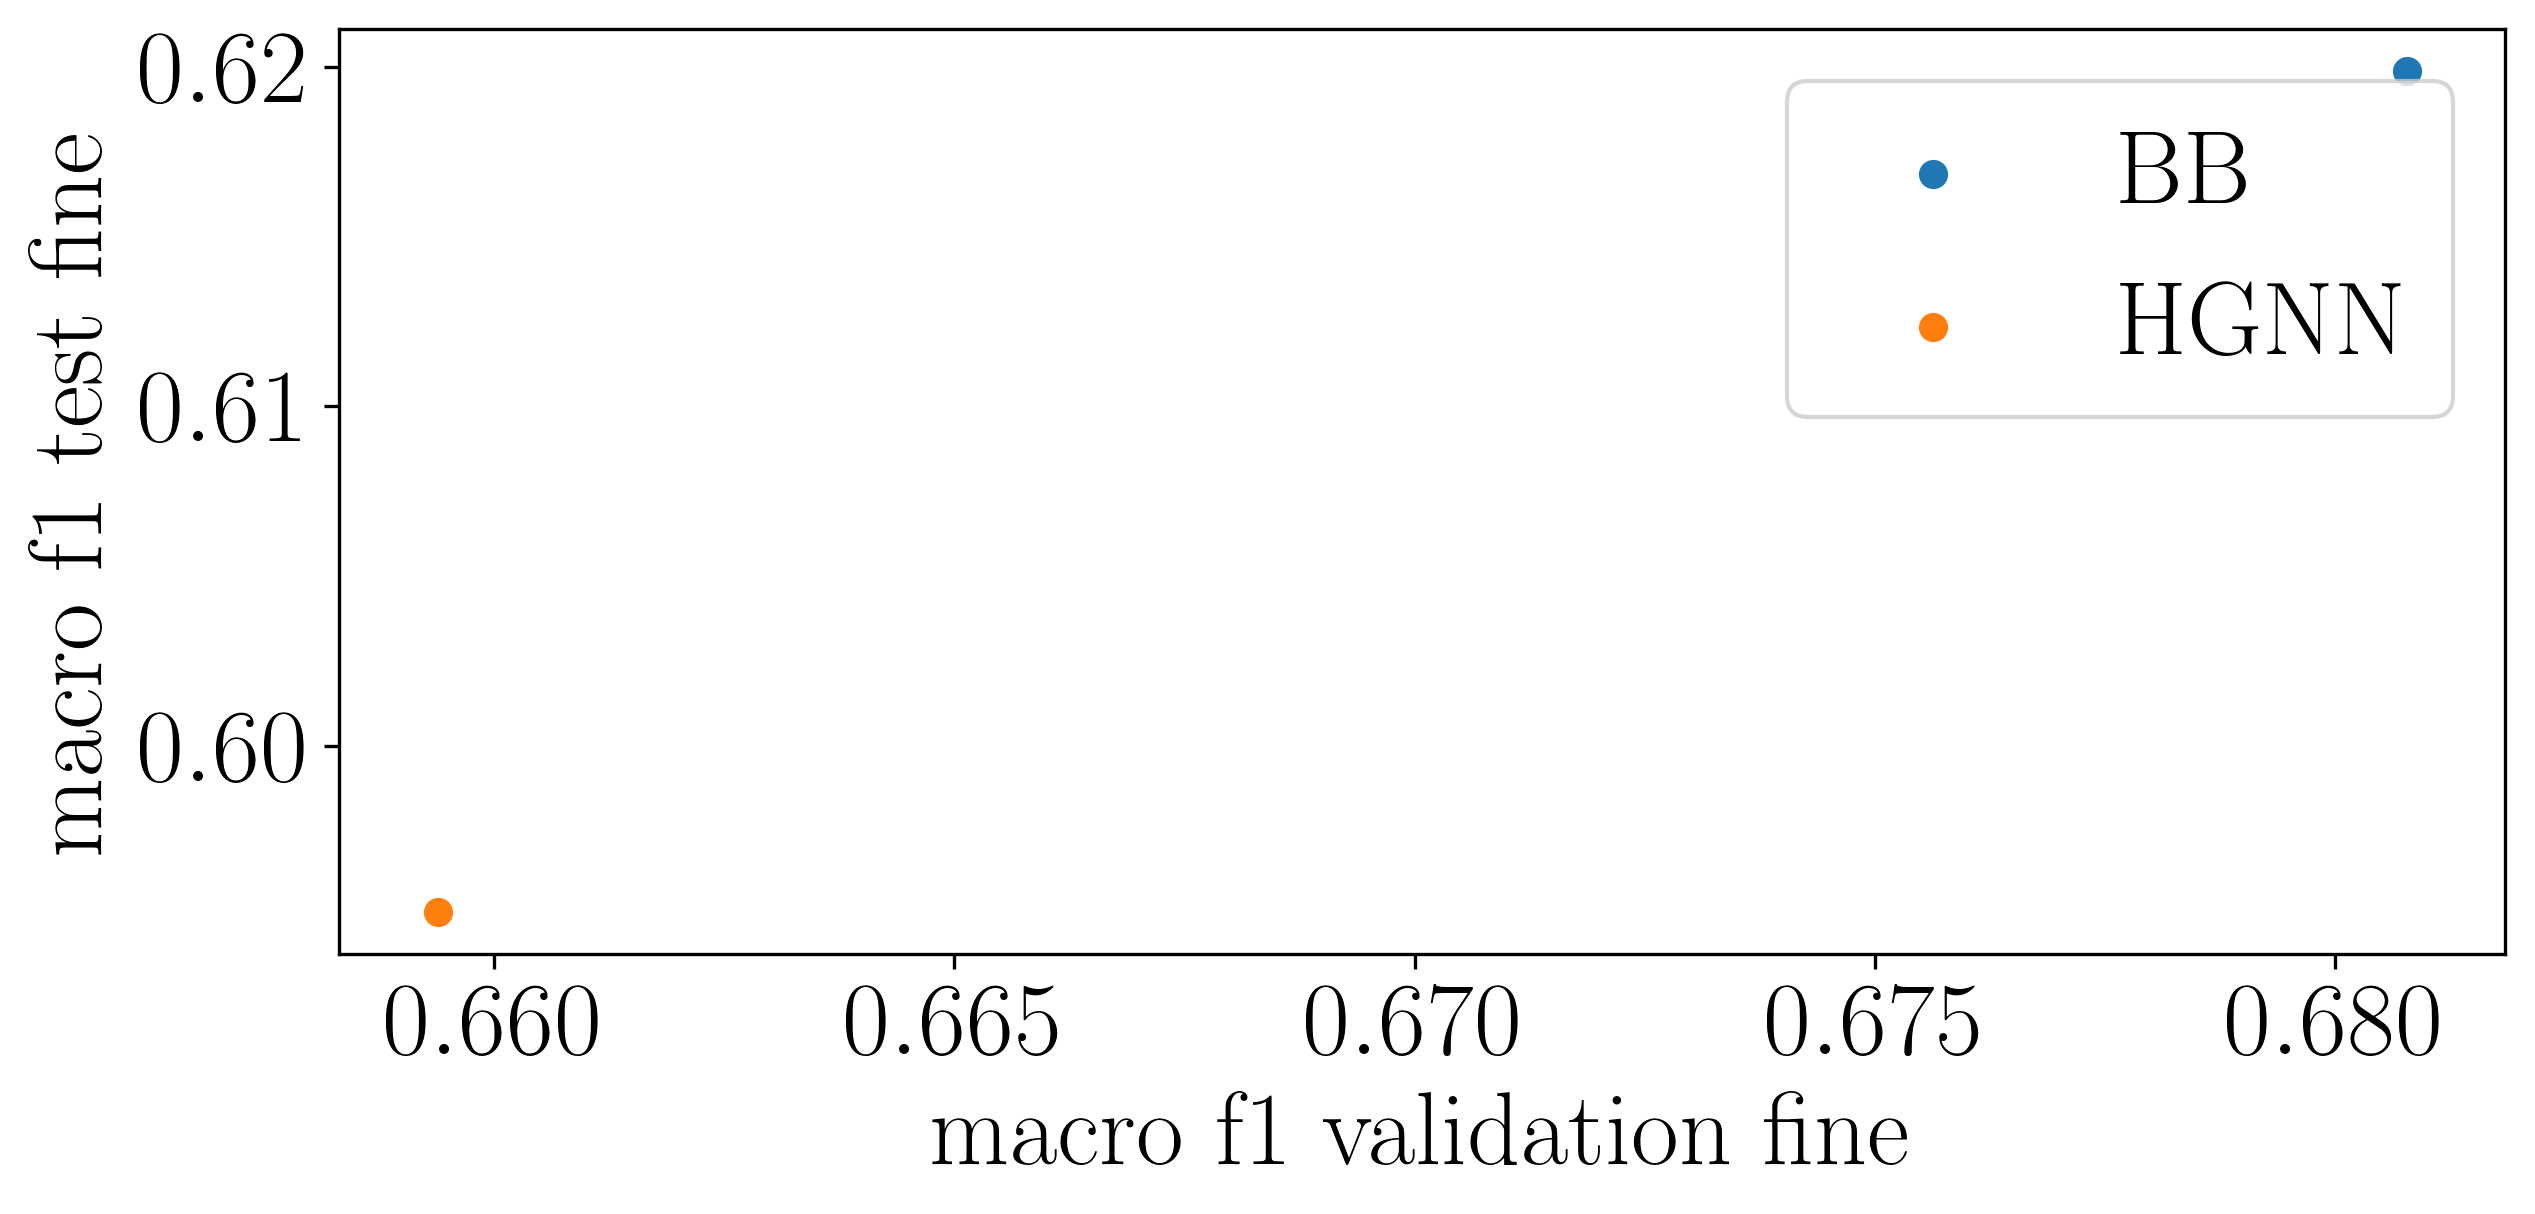

In [19]:
ts.trialScatter('macro f1 validation fine', 'macro f1 test fine', aggregatedBy='modelType', save_plot=True)

Print scatter plot

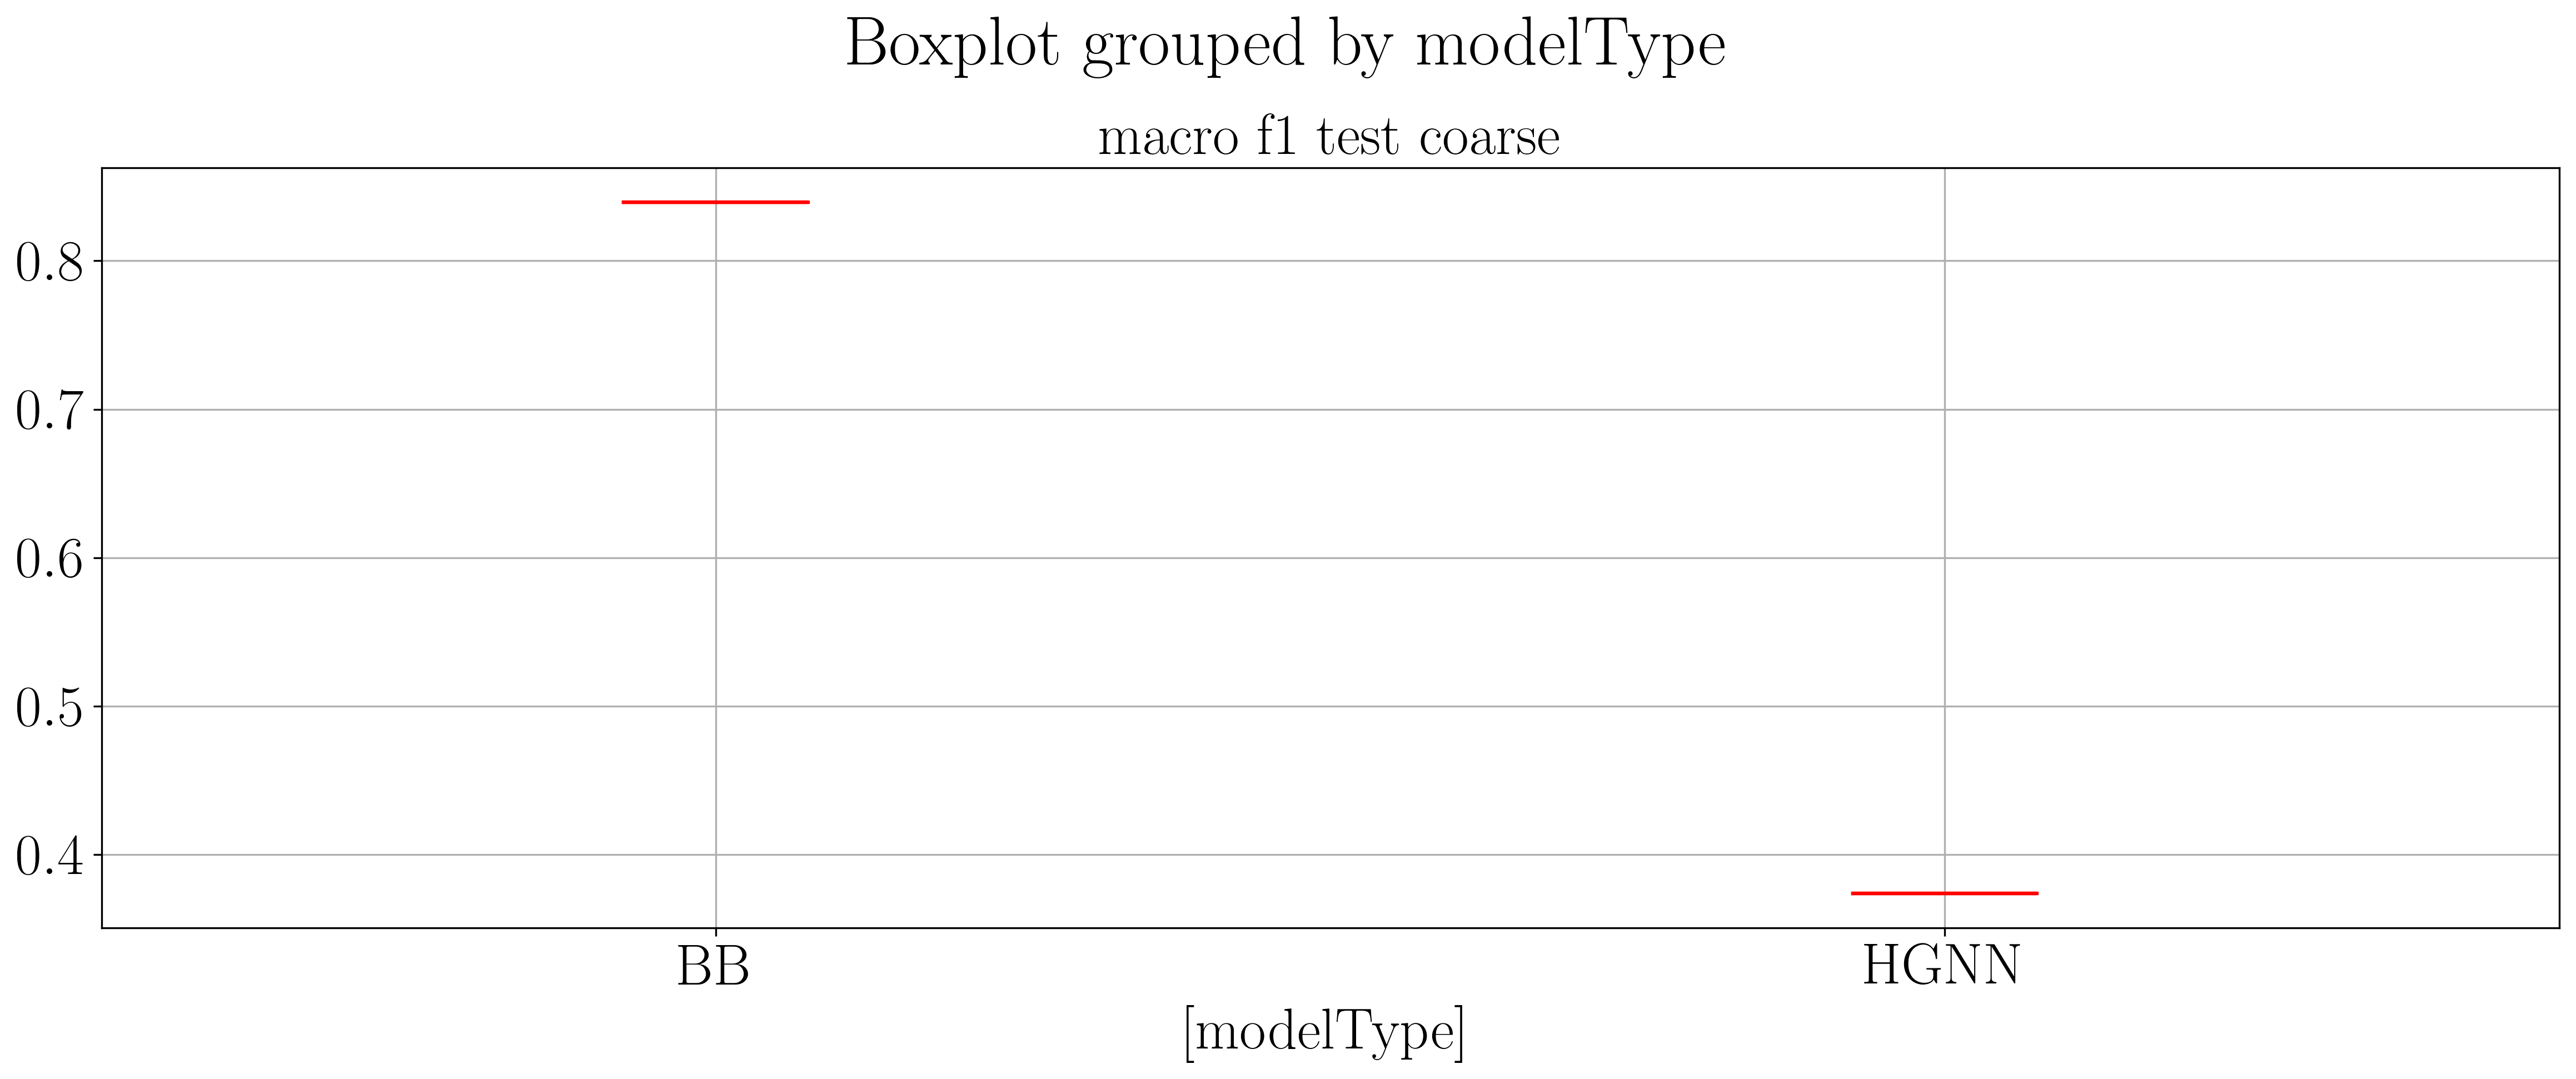

In [21]:
ts.pandasBoxplot(['macro f1 test coarse'], ['modelType'])

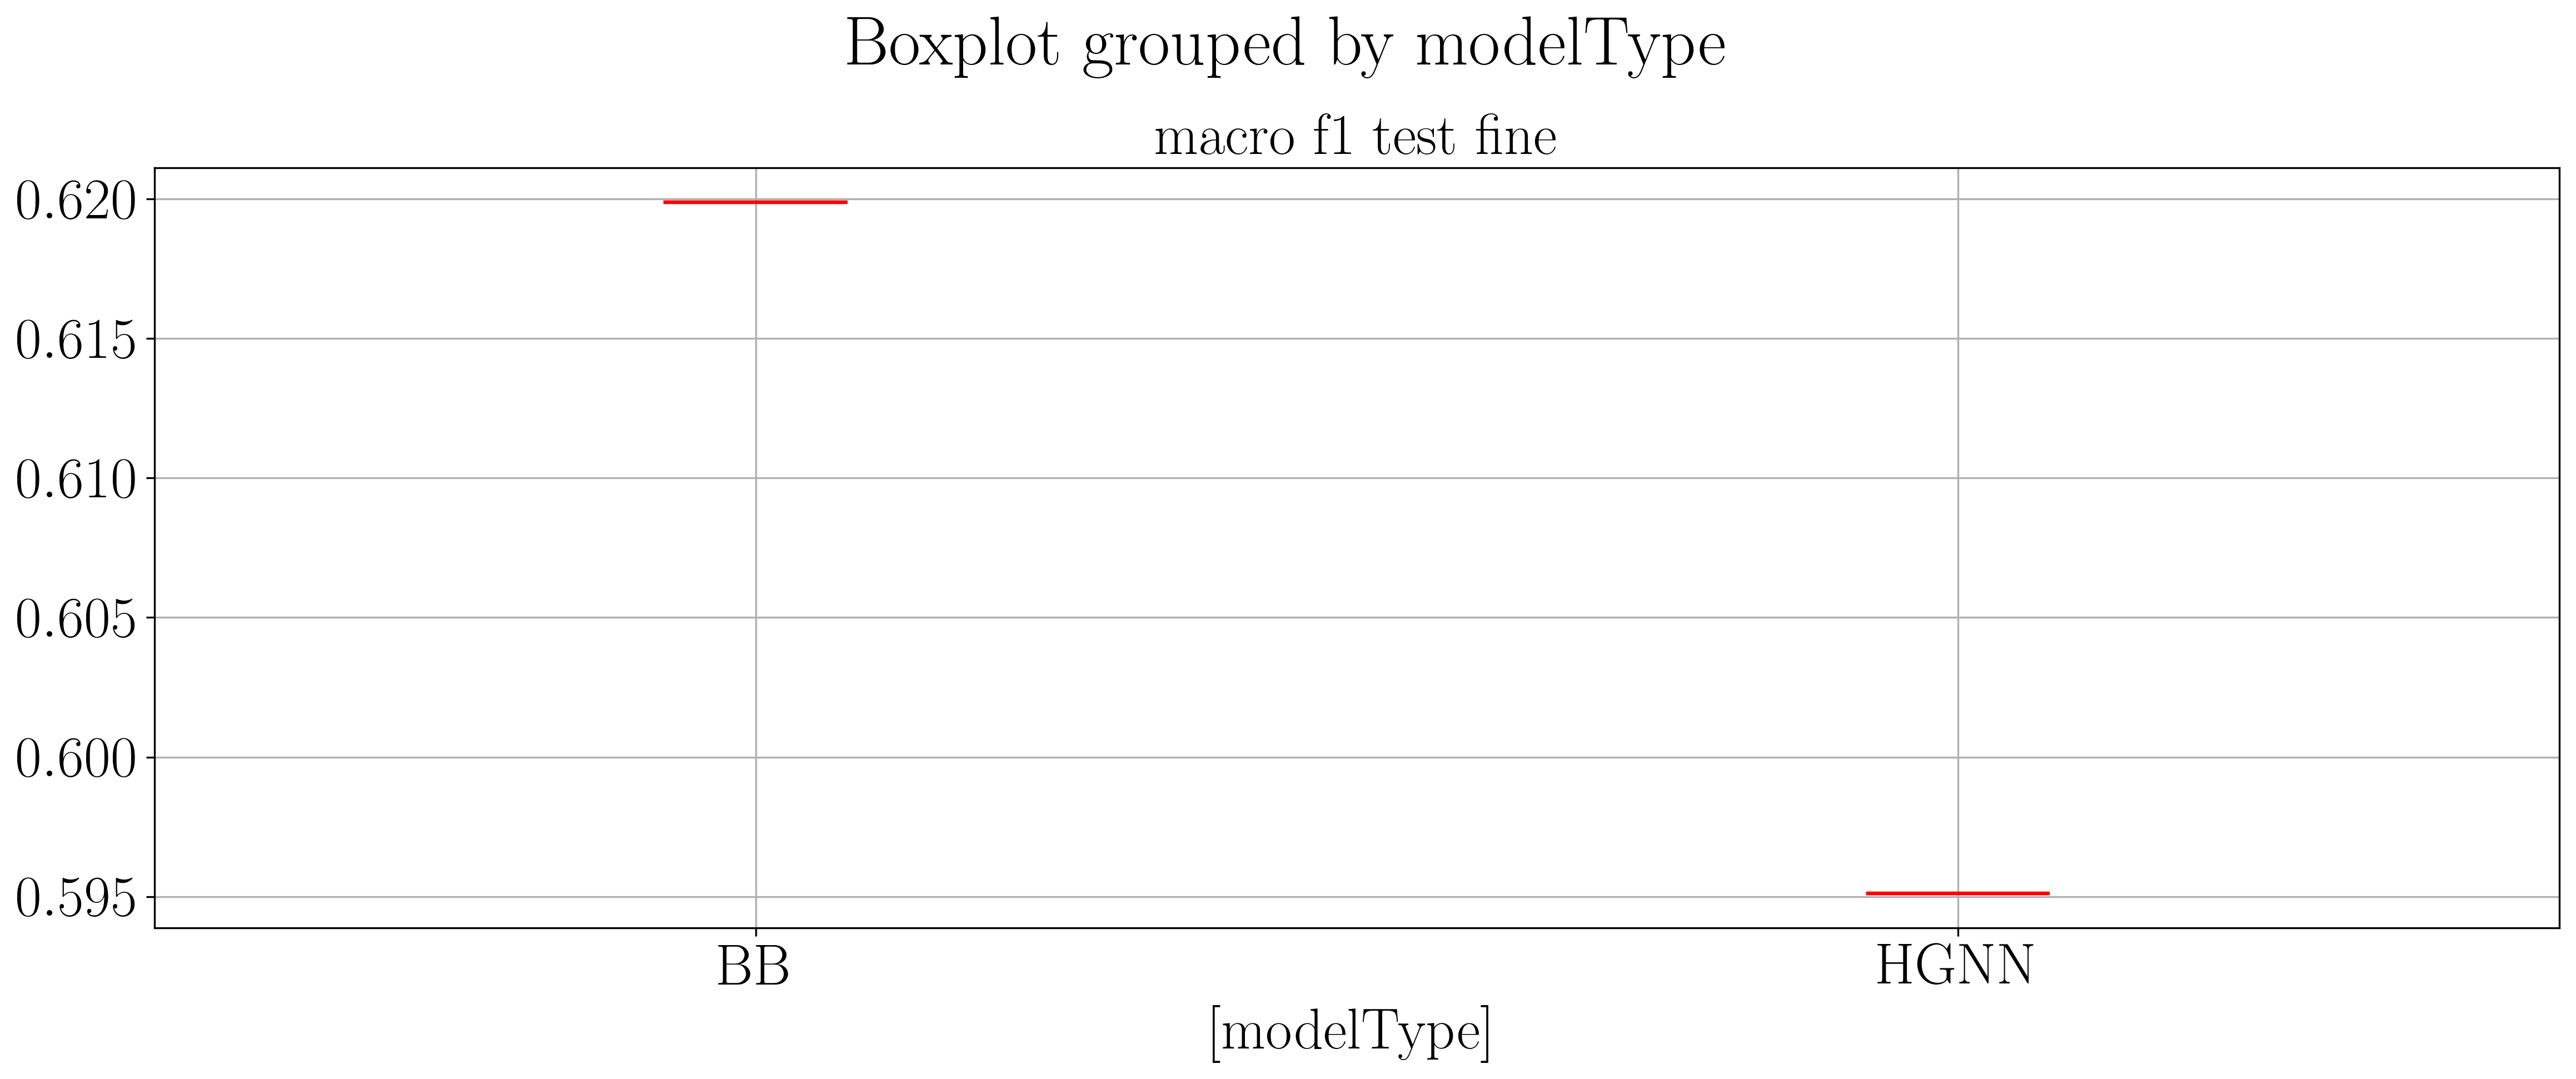

In [22]:
ts.pandasBoxplot(['macro f1 test fine'], ['modelType'])

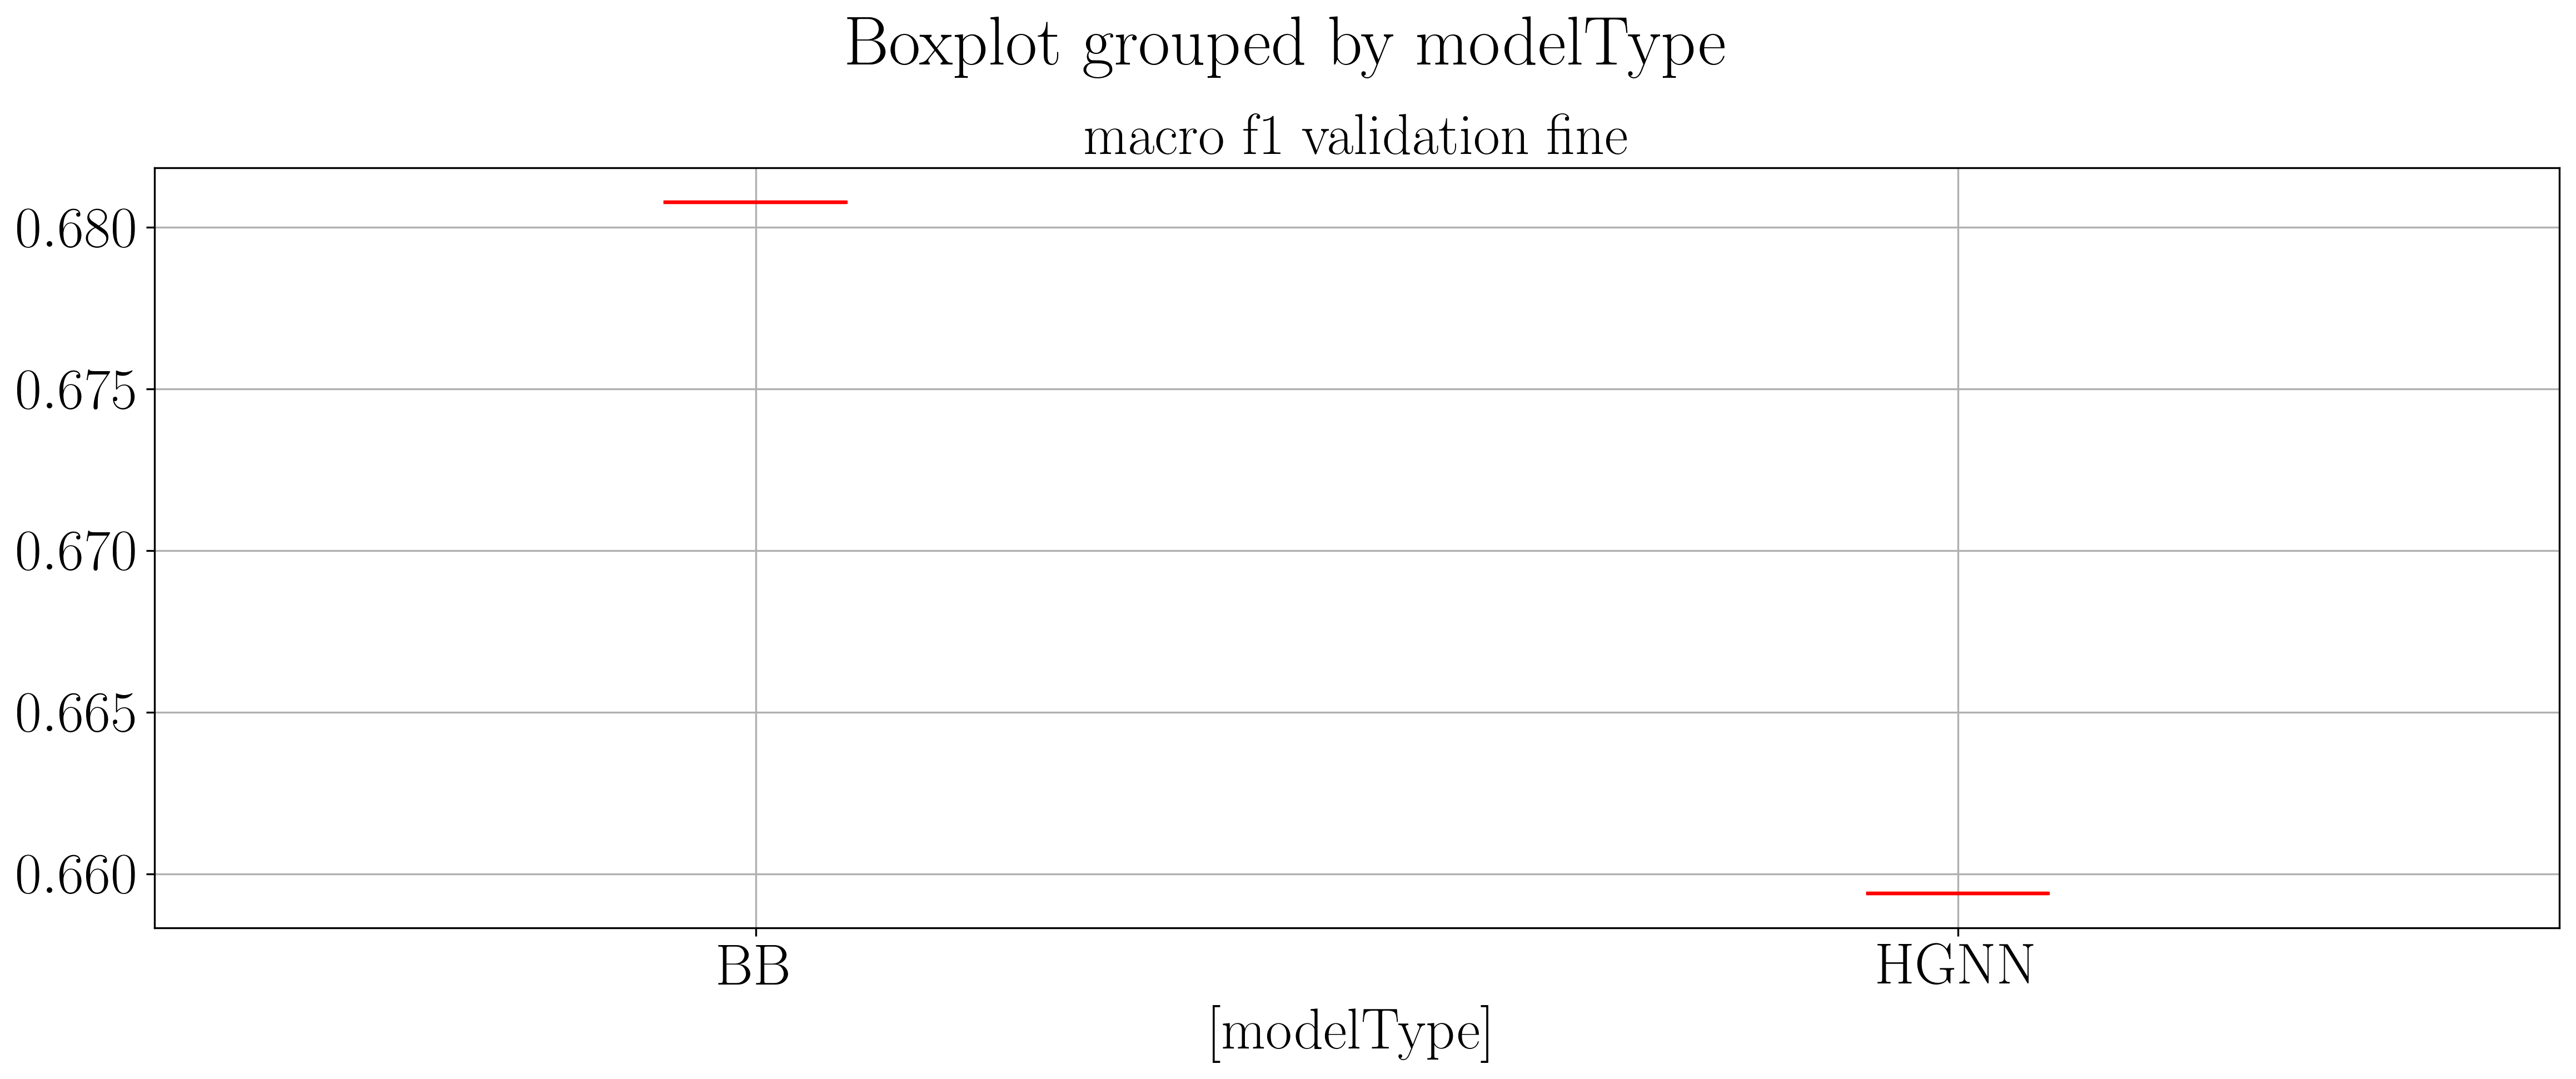

In [23]:
ts.pandasBoxplot(['macro f1 validation fine'], ['modelType'])

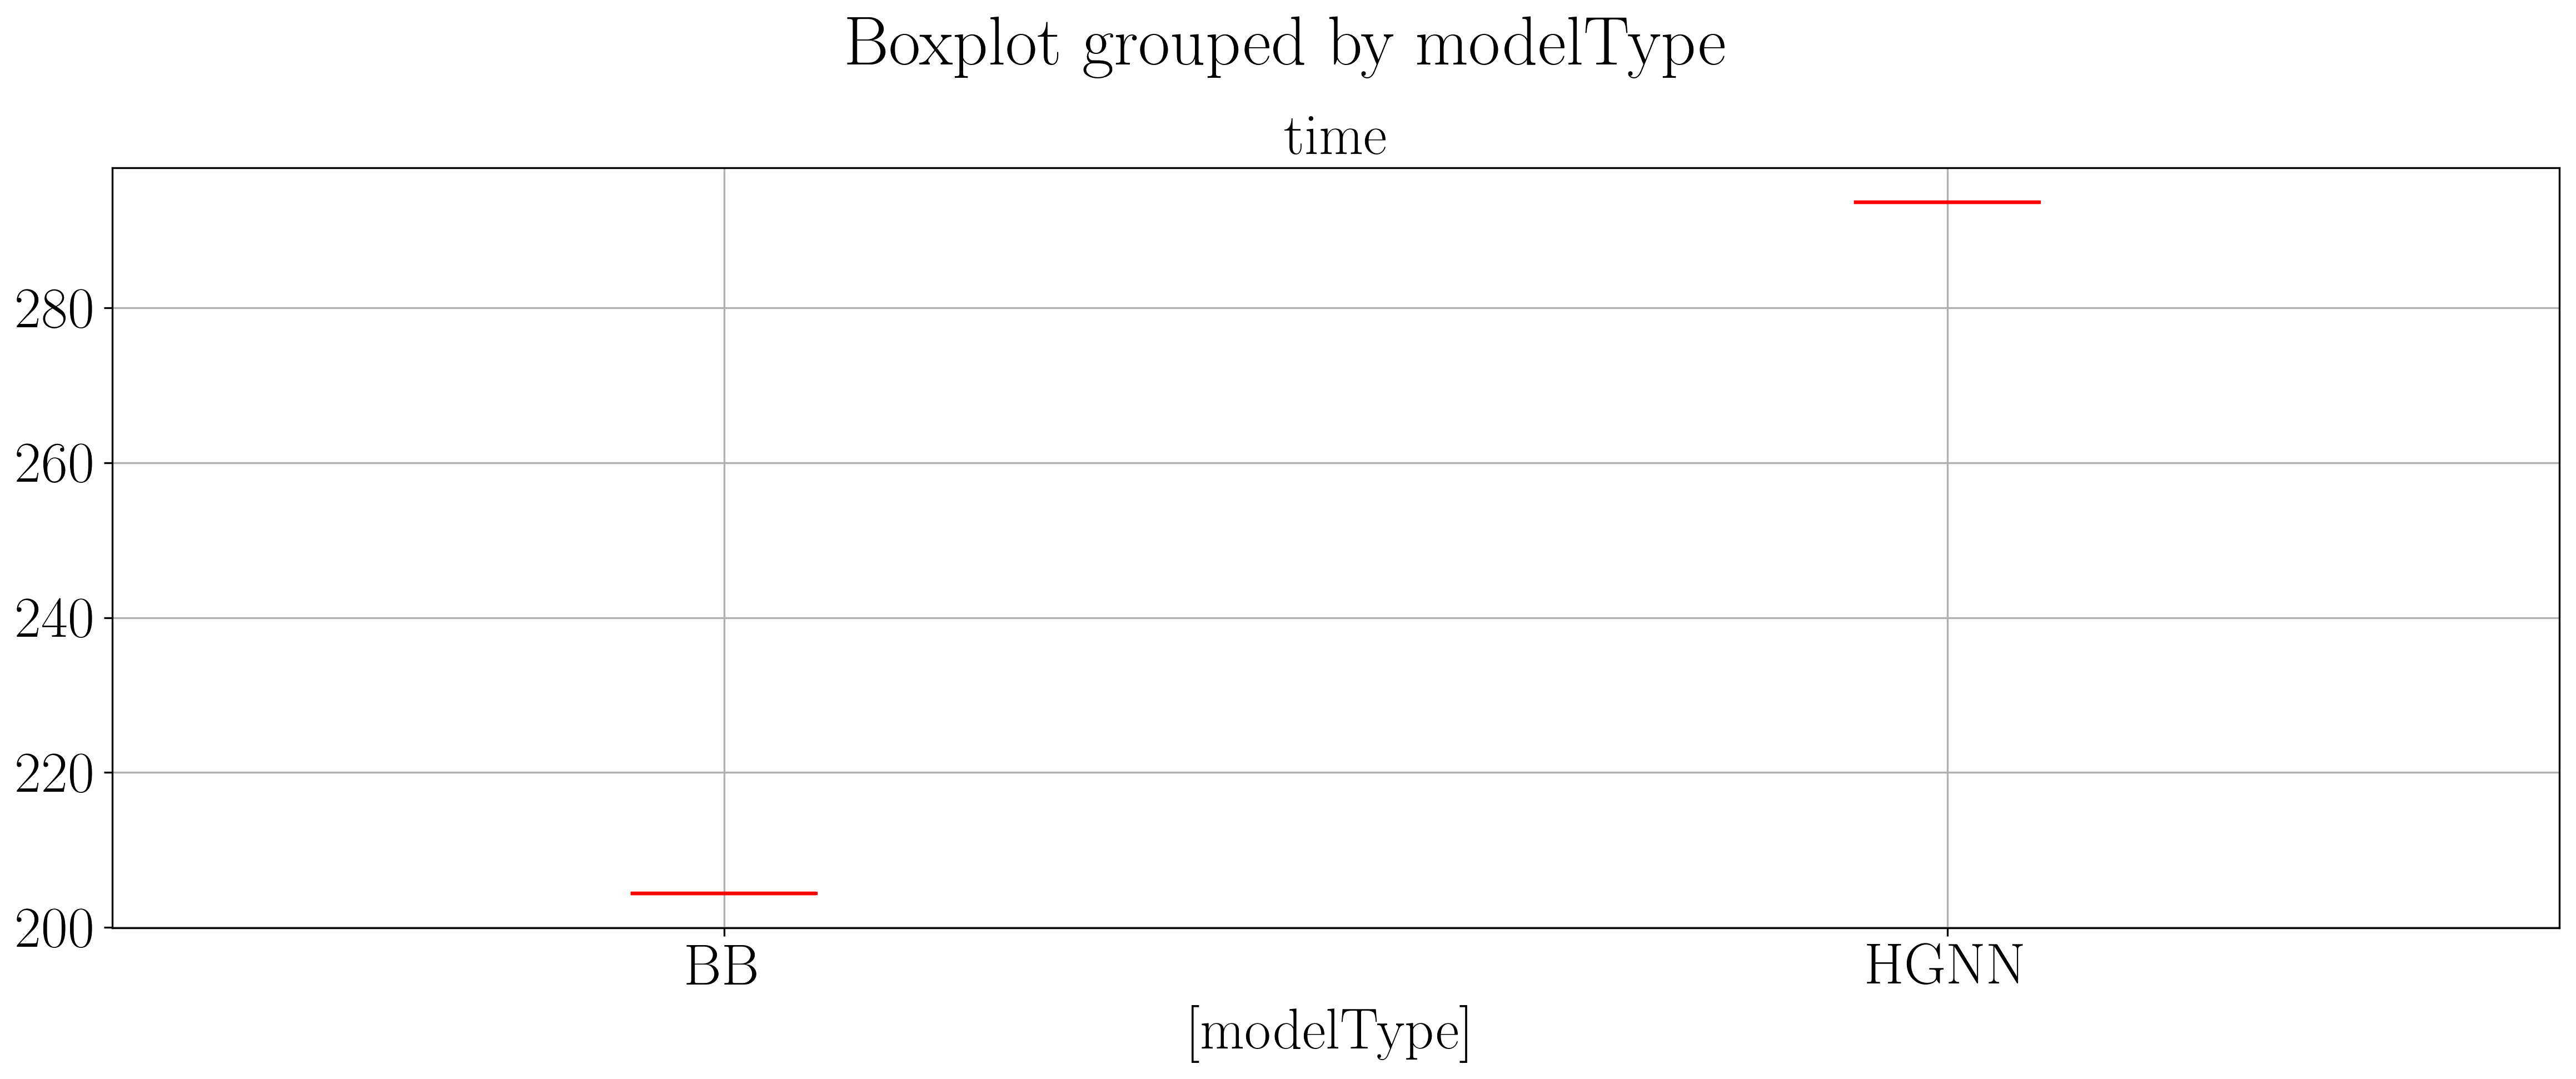

In [24]:
ts.pandasBoxplot(['time'], ['modelType'])

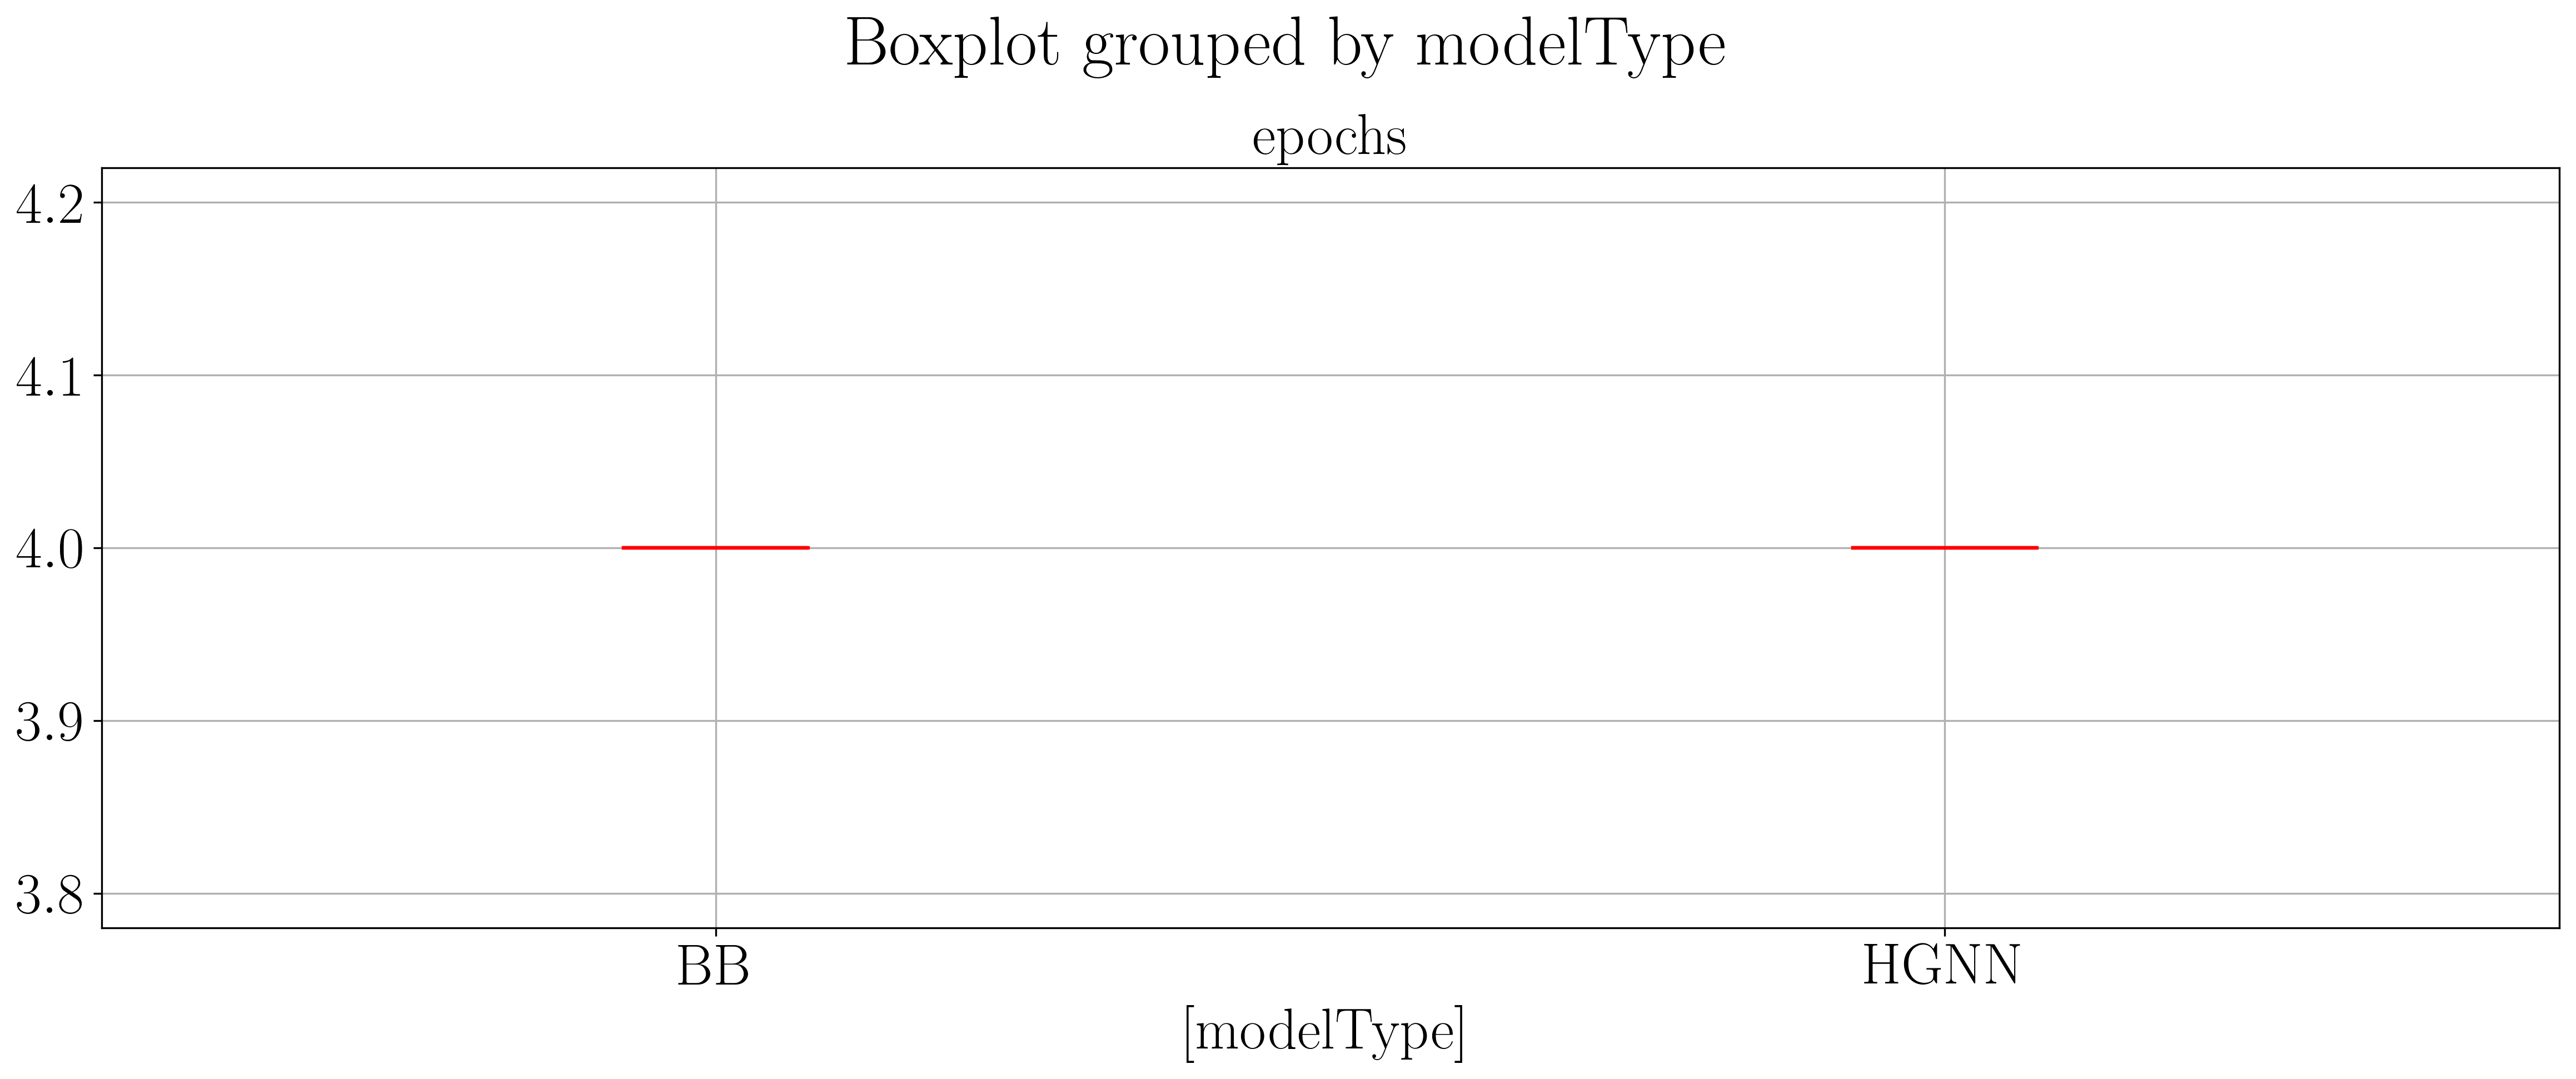

In [25]:
ts.pandasBoxplot(['epochs'], ['modelType'])